In [1]:
model_name = 'conformer'

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

from sklearn.model_selection import train_test_split

import numpy as np

from braindecode.models import EEGConformer

from tensorflow.keras import utils as np_utils
from torch.utils.data import DataLoader, TensorDataset, random_split

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [7]:
from processing_eeg_methods.data_utils import (
    get_dataset_basic_info,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from processing_eeg_methods.data_loaders import load_data_labels_based_on_dataset
from processing_eeg_methods.share import datasets_basic_infos
from collections import Counter

dataset_name = "braincommand"  # Only two things I should be able to change

dataset_info = get_dataset_basic_info(datasets_basic_infos, dataset_name)

data_path = r"C:\Users\rosit\Documents\workprojects\bci_complete\EEG-Classifiers-Ensemble\Datasets\braincommand_dataset"

Load calibration and singleplayer with labels 0 and 1, respectively.

Load calibration from the clean .set file after EEGLAB manual rejection.

In [8]:
# import mne
# import numpy as np
# 
# _, X, y = load_data_labels_based_on_dataset(
#     dataset_info,
#     subject_id,
#     data_path,
#     game_mode="calibration3",
# )

In [ ]:
subject_ids = [1,8,10,11,12,15,16,19,20,21,22,23,25,26,27,30,31,33,34,35,36,37,38,39,40,41]
results_df = pd.DataFrame(columns=['subject_id', 'test_accuracy'])

# Loop through each subject
for subject_id in subject_ids:

    epochs_calibration, X_calibration, y_calibration_original = load_data_labels_based_on_dataset(
        dataset_info,
        subject_id,
        data_path,
        game_mode="calibration3",
    )
    
    epochs_singleplayer, X_singleplayer, y_singleplayer_original = load_data_labels_based_on_dataset(
        dataset_info,
        subject_id,
        data_path,
        game_mode="singleplayer",
    )
    y_calibration = [0] * len(y_calibration_original)
    y_singleplayer = [1] * len(y_singleplayer_original)
    
    X = np.concatenate((X_calibration, X_singleplayer), axis=0)
    y = y_calibration + y_singleplayer
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Split the temp data into 50% test and 50% validation, resulting in 25% of the original data each
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print(y_train)
    num_classess = len(set(y_train))
    print(f'There are {num_classess} unique classes in the dataset')
    
    kernels, chans, samples = 1, dataset_info["#_channels"], dataset_info["samples"]
    
    # y_train = y_train - 1
    # y_val = y_val - 1
    # y_test = y_test - 1
    
    # X_train      = X_train.reshape(X_train.shape[0], chans, samples)
    # X_val   = X_val.reshape(X_val.shape[0], chans, samples)
    # X_test       = X_test.reshape(X_test.shape[0], chans, samples)
    
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Keep as integers
    
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    train_loader_size = len(train_loader)
    print(f"Number of batches in train_loader: {train_loader_size}")
    
    counts = Counter(y)
    
    total_samples = sum(counts.values())
    
    num_classes = len(counts)
    
    class_weights = {class_label-1: total_samples / (num_classes * count) for class_label, count in counts.items()}
    
    print(class_weights)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = 'cpu'
    
    n_classes = dataset_info["#_class"]
    classes = list(range(n_classes))
    
    n_outputs = dataset_info["#_class"]
    n_chans = dataset_info["#_channels"]
    n_filters_time = 40
    filter_time_length = 25
    pool_time_length = 75
    pool_time_stride = 15
    drop_prob = 0.5
    att_depth = 6
    att_heads = 10
    att_drop_prob = 0.5
    final_fc_length = 640
    return_features = False
    n_times = dataset_info["samples"]
    chs_info = None
    input_window_seconds = None
    sfreq = dataset_info["sample_rate"]
    add_log_softmax = True
    
    # Initialize the EEGConformer model
    conformer = EEGConformer(
        n_outputs=n_outputs,
        n_chans=n_chans,
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
        drop_prob=drop_prob,
        att_depth=att_depth,
        att_heads=att_heads,
        att_drop_prob=att_drop_prob,
        final_fc_length=final_fc_length,
        return_features=return_features,
        n_times=n_times,
        chs_info=chs_info,
        input_window_seconds=input_window_seconds,
        sfreq=sfreq,
        add_log_softmax=add_log_softmax
    )
    conformer = conformer.to(device)
    
    print(conformer)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(conformer.parameters(), lr =  0.0002,betas  = [0.5, 0.999])
    
    import torch
    
    conformer.to(device)
    
    # Create a dummy input with the correct shape and move it to the same device
    dummy_input = torch.randn(kernels, chans, samples).to(device)  # Batch size
    
    # Pass the dummy input through the model up to the transformer encoder
    try:
        with torch.no_grad():  # Disable gradient calculation for inference
            x = torch.unsqueeze(dummy_input, dim=1)  # Add an extra dimension to match input shape
            x = conformer.patch_embedding(x)  # Pass through Patch Embedding
            x = conformer.transformer(x)  # Pass through Transformer Encoder
            
            # Get the shape after the transformer and calculate the new `final_fc_length`
            print(f"Output shape after transformer: {x.shape}")
            final_fc_length_calculated = x.shape[1] * x.shape[2]
            print(f"Calculated `final_fc_length`: {final_fc_length_calculated}")
    
    except Exception as e:
        print("Error during partial forward pass:", str(e))
        
        
    num_epochs = 250
    ## TRAIN
    for epoch in range(num_epochs):
        conformer.train()
        
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            
            outputs = conformer(X_batch)
            loss = criterion(outputs, y_batch)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
    
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    ## Validation
        conformer.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
    
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    
                outputs = conformer(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
    
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == y_batch).sum().item()
                total_predictions += y_batch.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = correct_predictions / total_predictions
    
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        ## TEST
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
    
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = conformer(X_batch)
            
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)
    
    test_loss /= len(test_loader)
    test_accuracy = correct_predictions / total_predictions
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    temp_df = pd.DataFrame({'subject_id': [subject_id], 'test_accuracy': [test_accuracy]})
    
    # Concatenate the temporary dataframe with the results dataframe
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

mean_accuracy = results_df['test_accuracy'].mean()
std_accuracy = results_df['test_accuracy'].std()
min_accuracy = results_df['test_accuracy'].min()
max_accuracy = results_df['test_accuracy'].max()

# Report the results
print(f"Mean Test Accuracy: {mean_accuracy:.2f}")
print(f"Test Accuracy Standard Deviation: {std_accuracy:.2f}")
print(f"Minimum Test Accuracy: {min_accuracy:.2f}")
print(f"Maximum Test Accuracy: {max_accuracy:.2f}")

label 0 is 57
label 1 is 57
label 2 is 57
label 3 is 57
Not setting metadata
228 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated
label 0 is 100
label 1 is 103
label 2 is 51
label 3 is 22
Not setting metadata
276 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated
[0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2652, Accuracy: 0.4524
Validation Loss: 1.1219, Validation Accuracy: 0.5556
Epoch [2/250], Loss: 0.8110, Accuracy: 0.7857
Validation Loss: 1.5107, Validation Accuracy: 0.5556
Epoch [3/250], Loss: 0.4551, Accuracy: 0.9325
Validation Loss: 2.0413, Validation Accuracy: 0.5556
Epoch [4/250], Loss: 0.2215, Accuracy: 1.0000
Validation Loss: 2.8818, Validation Accuracy: 0.5556
Epoch [5/250], Loss: 0.1215, Accuracy: 0.9960
Validation Loss: 3.5250, Validation Accuracy: 0.5556
Epoch [6/250], Loss: 0.0664, Accuracy: 0.9960
Validation Loss: 3.9598, Validation Accuracy: 0.5556
Epoch [7/250], Loss: 0.0481, Accuracy: 1.0000
Validation Loss: 4.2868, Validation Accuracy: 0.5556
Epoch [8/250], Loss: 0.0355, Accuracy: 1.0000
Validation Loss: 4.5537, Validation Accuracy: 0.5556
Epoch [9/250], Loss: 0.0306, Accuracy: 1.0000
Validation Loss: 4.8452, Validation Accuracy: 0.5556
Epoch [10/250], Loss: 0.0199, Accuracy: 1.0000
Validation Loss: 4.9812, Validation Accuracy: 0.5556
Epoch [11

C:\Users\rosit\AppData\Local\Temp\ipykernel_20448\673908621.py:239: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


label 0 is 57
label 1 is 57
label 2 is 57
label 3 is 57
Not setting metadata
228 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated
label 0 is 85
label 1 is 102
label 2 is 65
label 3 is 23
Not setting metadata
275 matching events found
Setting baseline interval to [0.0, 1.296] s
Applying baseline correction (mode: mean)
0 projection items activated
[1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2233, Accuracy: 0.4263
Validation Loss: 0.9335, Validation Accuracy: 0.3889
Epoch [2/250], Loss: 0.9597, Accuracy: 0.5618
Validation Loss: 0.8157, Validation Accuracy: 0.3889
Epoch [3/250], Loss: 0.7902, Accuracy: 0.5697
Validation Loss: 0.8053, Validation Accuracy: 0.3889
Epoch [4/250], Loss: 0.6998, Accuracy: 0.6853
Validation Loss: 1.2392, Validation Accuracy: 0.3889
Epoch [5/250], Loss: 0.5929, Accuracy: 0.7131
Validation Loss: 1.5709, Validation Accuracy: 0.3889
Epoch [6/250], Loss: 0.4479, Accuracy: 0.8088
Validation Loss: 2.8103, Validation Accuracy: 0.3889
Epoch [7/250], Loss: 0.2800, Accuracy: 0.8924
Validation Loss: 4.2379, Validation Accuracy: 0.3889
Epoch [8/250], Loss: 0.2020, Accuracy: 0.9522
Validation Loss: 5.0967, Validation Accuracy: 0.3889
Epoch [9/250], Loss: 0.1278, Accuracy: 0.9562
Validation Loss: 5.4627, Validation Accuracy: 0.3889
Epoch [10/250], Loss: 0.0879, Accuracy: 0.9761
Validation Loss: 5.9563, Validation Accuracy: 0.3889
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3109, Accuracy: 0.3485
Validation Loss: 1.0624, Validation Accuracy: 0.4876
Epoch [2/250], Loss: 1.0430, Accuracy: 0.5187
Validation Loss: 0.8303, Validation Accuracy: 0.4876
Epoch [3/250], Loss: 0.8117, Accuracy: 0.6141
Validation Loss: 0.8922, Validation Accuracy: 0.4876
Epoch [4/250], Loss: 0.6646, Accuracy: 0.6888
Validation Loss: 1.0636, Validation Accuracy: 0.4876
Epoch [5/250], Loss: 0.4721, Accuracy: 0.8631
Validation Loss: 1.7289, Validation Accuracy: 0.4876
Epoch [6/250], Loss: 0.2757, Accuracy: 0.9544
Validation Loss: 2.4353, Validation Accuracy: 0.4876
Epoch [7/250], Loss: 0.1205, Accuracy: 0.9959
Validation Loss: 3.1060, Validation Accuracy: 0.4876
Epoch [8/250], Loss: 0.0658, Accuracy: 1.0000
Validation Loss: 3.5458, Validation Accuracy: 0.4876
Epoch [9/250], Loss: 0.0434, Accuracy: 1.0000
Validation Loss: 3.8763, Validation Accuracy: 0.4876
Epoch [10/250], Loss: 0.0288, Accuracy: 1.0000
Validation Loss: 4.2002, Validation Accuracy: 0.4876
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2498, Accuracy: 0.3994
Validation Loss: 0.9561, Validation Accuracy: 0.6154
Epoch [2/250], Loss: 0.8946, Accuracy: 0.6775
Validation Loss: 0.7816, Validation Accuracy: 0.6154
Epoch [3/250], Loss: 0.7477, Accuracy: 0.6716
Validation Loss: 0.7171, Validation Accuracy: 0.6154
Epoch [4/250], Loss: 0.7295, Accuracy: 0.6361
Validation Loss: 0.6893, Validation Accuracy: 0.6154
Epoch [5/250], Loss: 0.7043, Accuracy: 0.6450
Validation Loss: 0.7239, Validation Accuracy: 0.6154
Epoch [6/250], Loss: 0.7316, Accuracy: 0.6420
Validation Loss: 0.6918, Validation Accuracy: 0.6154
Epoch [7/250], Loss: 0.7098, Accuracy: 0.6183
Validation Loss: 0.6767, Validation Accuracy: 0.6154
Epoch [8/250], Loss: 0.6586, Accuracy: 0.6538
Validation Loss: 0.7410, Validation Accuracy: 0.6154
Epoch [9/250], Loss: 0.7045, Accuracy: 0.6598
Validation Loss: 0.6822, Validation Accuracy: 0.6154
Epoch [10/250], Loss: 0.6913, Accuracy: 0.6479
Validation Loss: 0.6820, Validation Accuracy: 0.6154
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2575, Accuracy: 0.3825
Validation Loss: 0.8677, Validation Accuracy: 0.5594
Epoch [2/250], Loss: 0.8830, Accuracy: 0.6070
Validation Loss: 0.7802, Validation Accuracy: 0.5594
Epoch [3/250], Loss: 0.8079, Accuracy: 0.5684
Validation Loss: 0.7650, Validation Accuracy: 0.5594
Epoch [4/250], Loss: 0.7734, Accuracy: 0.5404
Validation Loss: 0.7524, Validation Accuracy: 0.5594
Epoch [5/250], Loss: 0.7036, Accuracy: 0.6105
Validation Loss: 0.7376, Validation Accuracy: 0.5594
Epoch [6/250], Loss: 0.7333, Accuracy: 0.5579
Validation Loss: 0.7417, Validation Accuracy: 0.5594
Epoch [7/250], Loss: 0.7050, Accuracy: 0.6000
Validation Loss: 0.7664, Validation Accuracy: 0.5594
Epoch [8/250], Loss: 0.7328, Accuracy: 0.5965
Validation Loss: 0.7328, Validation Accuracy: 0.5594
Epoch [9/250], Loss: 0.6968, Accuracy: 0.5860
Validation Loss: 0.8033, Validation Accuracy: 0.5594
Epoch [10/250], Loss: 0.7069, Accuracy: 0.5789
Validation Loss: 0.7819, Validation Accuracy: 0.5594
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2438, Accuracy: 0.3925
Validation Loss: 1.0049, Validation Accuracy: 0.5113
Epoch [2/250], Loss: 0.9723, Accuracy: 0.5698
Validation Loss: 0.8771, Validation Accuracy: 0.5113
Epoch [3/250], Loss: 0.8117, Accuracy: 0.6113
Validation Loss: 0.8558, Validation Accuracy: 0.5113
Epoch [4/250], Loss: 0.8309, Accuracy: 0.5509
Validation Loss: 0.7426, Validation Accuracy: 0.5113
Epoch [5/250], Loss: 0.8512, Accuracy: 0.4943
Validation Loss: 0.8524, Validation Accuracy: 0.5113
Epoch [6/250], Loss: 0.7422, Accuracy: 0.6226
Validation Loss: 0.7795, Validation Accuracy: 0.5113
Epoch [7/250], Loss: 0.7845, Accuracy: 0.5434
Validation Loss: 0.7801, Validation Accuracy: 0.5113
Epoch [8/250], Loss: 0.7880, Accuracy: 0.5509
Validation Loss: 0.7881, Validation Accuracy: 0.5113
Epoch [9/250], Loss: 0.7732, Accuracy: 0.5623
Validation Loss: 0.8008, Validation Accuracy: 0.5113
Epoch [10/250], Loss: 0.7430, Accuracy: 0.5585
Validation Loss: 0.7709, Validation Accuracy: 0.5113
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3631, Accuracy: 0.2706
Validation Loss: 1.1225, Validation Accuracy: 0.4037
Epoch [2/250], Loss: 1.1396, Accuracy: 0.4954
Validation Loss: 0.9972, Validation Accuracy: 0.4037
Epoch [3/250], Loss: 0.9662, Accuracy: 0.5138
Validation Loss: 0.8860, Validation Accuracy: 0.4037
Epoch [4/250], Loss: 0.8522, Accuracy: 0.5550
Validation Loss: 0.7683, Validation Accuracy: 0.4037
Epoch [5/250], Loss: 0.7895, Accuracy: 0.5459
Validation Loss: 0.7825, Validation Accuracy: 0.4037
Epoch [6/250], Loss: 0.7854, Accuracy: 0.5229
Validation Loss: 0.8038, Validation Accuracy: 0.4037
Epoch [7/250], Loss: 0.8190, Accuracy: 0.5092
Validation Loss: 0.8022, Validation Accuracy: 0.4037
Epoch [8/250], Loss: 0.7717, Accuracy: 0.5138
Validation Loss: 0.8271, Validation Accuracy: 0.4037
Epoch [9/250], Loss: 0.7818, Accuracy: 0.5183
Validation Loss: 0.8700, Validation Accuracy: 0.4037
Epoch [10/250], Loss: 0.7643, Accuracy: 0.5413
Validation Loss: 0.8450, Validation Accuracy: 0.4037
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.4070, Accuracy: 0.2311
Validation Loss: 1.1317, Validation Accuracy: 0.6111
Epoch [2/250], Loss: 1.1767, Accuracy: 0.5498
Validation Loss: 0.8865, Validation Accuracy: 0.6111
Epoch [3/250], Loss: 0.9762, Accuracy: 0.5777
Validation Loss: 0.7729, Validation Accuracy: 0.6111
Epoch [4/250], Loss: 0.8789, Accuracy: 0.5737
Validation Loss: 0.7265, Validation Accuracy: 0.6111
Epoch [5/250], Loss: 0.8244, Accuracy: 0.5139
Validation Loss: 0.7323, Validation Accuracy: 0.6111
Epoch [6/250], Loss: 0.8034, Accuracy: 0.5259
Validation Loss: 0.7440, Validation Accuracy: 0.6111
Epoch [7/250], Loss: 0.7672, Accuracy: 0.5339
Validation Loss: 0.7177, Validation Accuracy: 0.6111
Epoch [8/250], Loss: 0.7208, Accuracy: 0.6016
Validation Loss: 0.7648, Validation Accuracy: 0.6111
Epoch [9/250], Loss: 0.7463, Accuracy: 0.5498
Validation Loss: 0.7482, Validation Accuracy: 0.6111
Epoch [10/250], Loss: 0.7175, Accuracy: 0.5936
Validation Loss: 0.8909, Validation Accuracy: 0.6111
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3024, Accuracy: 0.3255
Validation Loss: 1.0650, Validation Accuracy: 0.5312
Epoch [2/250], Loss: 1.0504, Accuracy: 0.5373
Validation Loss: 0.8153, Validation Accuracy: 0.5312
Epoch [3/250], Loss: 0.8453, Accuracy: 0.5294
Validation Loss: 0.7393, Validation Accuracy: 0.4688
Epoch [4/250], Loss: 0.8089, Accuracy: 0.4863
Validation Loss: 0.7444, Validation Accuracy: 0.4688
Epoch [5/250], Loss: 0.7759, Accuracy: 0.5333
Validation Loss: 0.7365, Validation Accuracy: 0.4688
Epoch [6/250], Loss: 0.7301, Accuracy: 0.6039
Validation Loss: 0.7212, Validation Accuracy: 0.4688
Epoch [7/250], Loss: 0.7350, Accuracy: 0.5725
Validation Loss: 0.7171, Validation Accuracy: 0.4688
Epoch [8/250], Loss: 0.7641, Accuracy: 0.5059
Validation Loss: 0.7056, Validation Accuracy: 0.4688
Epoch [9/250], Loss: 0.7649, Accuracy: 0.4902
Validation Loss: 0.7268, Validation Accuracy: 0.4688
Epoch [10/250], Loss: 0.7406, Accuracy: 0.5725
Validation Loss: 0.7604, Validation Accuracy: 0.4688
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.1574, Accuracy: 0.4549
Validation Loss: 0.8687, Validation Accuracy: 0.5899
Epoch [2/250], Loss: 0.8708, Accuracy: 0.5812
Validation Loss: 0.7232, Validation Accuracy: 0.5899
Epoch [3/250], Loss: 0.7537, Accuracy: 0.6209
Validation Loss: 0.7000, Validation Accuracy: 0.5899
Epoch [4/250], Loss: 0.7523, Accuracy: 0.5451
Validation Loss: 0.7225, Validation Accuracy: 0.5899
Epoch [5/250], Loss: 0.7357, Accuracy: 0.5848
Validation Loss: 0.7530, Validation Accuracy: 0.5899
Epoch [6/250], Loss: 0.7074, Accuracy: 0.6282
Validation Loss: 0.7168, Validation Accuracy: 0.5899
Epoch [7/250], Loss: 0.7259, Accuracy: 0.5560
Validation Loss: 0.8567, Validation Accuracy: 0.5899
Epoch [8/250], Loss: 0.6981, Accuracy: 0.6209
Validation Loss: 0.8798, Validation Accuracy: 0.5899
Epoch [9/250], Loss: 0.6725, Accuracy: 0.6282
Validation Loss: 1.0163, Validation Accuracy: 0.5899
Epoch [10/250], Loss: 0.6748, Accuracy: 0.6679
Validation Loss: 1.2410, Validation Accuracy: 0.5899
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2118, Accuracy: 0.4331
Validation Loss: 0.9225, Validation Accuracy: 0.5949
Epoch [2/250], Loss: 0.9243, Accuracy: 0.6497
Validation Loss: 0.7713, Validation Accuracy: 0.5949
Epoch [3/250], Loss: 0.7553, Accuracy: 0.6656
Validation Loss: 0.8070, Validation Accuracy: 0.4051
Epoch [4/250], Loss: 0.6302, Accuracy: 0.7293
Validation Loss: 1.4702, Validation Accuracy: 0.4051
Epoch [5/250], Loss: 0.4584, Accuracy: 0.8599
Validation Loss: 2.4705, Validation Accuracy: 0.4051
Epoch [6/250], Loss: 0.3028, Accuracy: 0.9045
Validation Loss: 3.3896, Validation Accuracy: 0.4051
Epoch [7/250], Loss: 0.1963, Accuracy: 0.9395
Validation Loss: 4.0602, Validation Accuracy: 0.4051
Epoch [8/250], Loss: 0.1664, Accuracy: 0.9522
Validation Loss: 4.4189, Validation Accuracy: 0.4051
Epoch [9/250], Loss: 0.1124, Accuracy: 0.9777
Validation Loss: 4.8605, Validation Accuracy: 0.4051
Epoch [10/250], Loss: 0.1485, Accuracy: 0.9522
Validation Loss: 5.1428, Validation Accuracy: 0.4051
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3685, Accuracy: 0.2518
Validation Loss: 1.2101, Validation Accuracy: 0.5000
Epoch [2/250], Loss: 1.1643, Accuracy: 0.5461
Validation Loss: 0.9619, Validation Accuracy: 0.5000
Epoch [3/250], Loss: 0.8786, Accuracy: 0.6525
Validation Loss: 0.7713, Validation Accuracy: 0.5000
Epoch [4/250], Loss: 0.7302, Accuracy: 0.7128
Validation Loss: 1.0273, Validation Accuracy: 0.5000
Epoch [5/250], Loss: 0.5871, Accuracy: 0.7589
Validation Loss: 2.1308, Validation Accuracy: 0.5000
Epoch [6/250], Loss: 0.3487, Accuracy: 0.9255
Validation Loss: 3.6137, Validation Accuracy: 0.5000
Epoch [7/250], Loss: 0.2382, Accuracy: 0.9326
Validation Loss: 4.5408, Validation Accuracy: 0.5000
Epoch [8/250], Loss: 0.1566, Accuracy: 0.9504
Validation Loss: 5.1046, Validation Accuracy: 0.5000
Epoch [9/250], Loss: 0.1402, Accuracy: 0.9610
Validation Loss: 5.0580, Validation Accuracy: 0.5000
Epoch [10/250], Loss: 0.1279, Accuracy: 0.9681
Validation Loss: 5.1398, Validation Accuracy: 0.5000
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3925, Accuracy: 0.3121
Validation Loss: 0.9680, Validation Accuracy: 0.6107
Epoch [2/250], Loss: 1.0442, Accuracy: 0.5738
Validation Loss: 0.7874, Validation Accuracy: 0.6107
Epoch [3/250], Loss: 0.8337, Accuracy: 0.6275
Validation Loss: 0.7073, Validation Accuracy: 0.6107
Epoch [4/250], Loss: 0.8053, Accuracy: 0.5839
Validation Loss: 0.6831, Validation Accuracy: 0.6107
Epoch [5/250], Loss: 0.7470, Accuracy: 0.6443
Validation Loss: 0.6742, Validation Accuracy: 0.6107
Epoch [6/250], Loss: 0.7496, Accuracy: 0.6208
Validation Loss: 0.6915, Validation Accuracy: 0.6107
Epoch [7/250], Loss: 0.7062, Accuracy: 0.6409
Validation Loss: 0.6676, Validation Accuracy: 0.6107
Epoch [8/250], Loss: 0.7140, Accuracy: 0.6107
Validation Loss: 0.6800, Validation Accuracy: 0.6107
Epoch [9/250], Loss: 0.7125, Accuracy: 0.6107
Validation Loss: 0.6969, Validation Accuracy: 0.5638
Epoch [10/250], Loss: 0.7026, Accuracy: 0.6309
Validation Loss: 0.7323, Validation Accuracy: 0.4228
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2828, Accuracy: 0.3778
Validation Loss: 0.9666, Validation Accuracy: 0.6000
Epoch [2/250], Loss: 0.9945, Accuracy: 0.5407
Validation Loss: 0.8088, Validation Accuracy: 0.6000
Epoch [3/250], Loss: 0.8397, Accuracy: 0.5667
Validation Loss: 0.7335, Validation Accuracy: 0.6000
Epoch [4/250], Loss: 0.7778, Accuracy: 0.5556
Validation Loss: 0.7183, Validation Accuracy: 0.6000
Epoch [5/250], Loss: 0.7922, Accuracy: 0.5741
Validation Loss: 0.7046, Validation Accuracy: 0.6000
Epoch [6/250], Loss: 0.7639, Accuracy: 0.5222
Validation Loss: 0.7114, Validation Accuracy: 0.6000
Epoch [7/250], Loss: 0.7441, Accuracy: 0.6000
Validation Loss: 0.7024, Validation Accuracy: 0.5926
Epoch [8/250], Loss: 0.7416, Accuracy: 0.5741
Validation Loss: 0.7032, Validation Accuracy: 0.6000
Epoch [9/250], Loss: 0.7338, Accuracy: 0.5852
Validation Loss: 0.7068, Validation Accuracy: 0.4296
Epoch [10/250], Loss: 0.7651, Accuracy: 0.5593
Validation Loss: 0.7513, Validation Accuracy: 0.4000
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2997, Accuracy: 0.4078
Validation Loss: 1.0542, Validation Accuracy: 0.4688
Epoch [2/250], Loss: 1.0640, Accuracy: 0.5333
Validation Loss: 0.9204, Validation Accuracy: 0.4688
Epoch [3/250], Loss: 0.8996, Accuracy: 0.5490
Validation Loss: 0.8086, Validation Accuracy: 0.4688
Epoch [4/250], Loss: 0.8221, Accuracy: 0.5529
Validation Loss: 0.7849, Validation Accuracy: 0.4688
Epoch [5/250], Loss: 0.8287, Accuracy: 0.5020
Validation Loss: 0.7460, Validation Accuracy: 0.4688
Epoch [6/250], Loss: 0.8560, Accuracy: 0.4588
Validation Loss: 0.7777, Validation Accuracy: 0.4688
Epoch [7/250], Loss: 0.7815, Accuracy: 0.5529
Validation Loss: 0.7447, Validation Accuracy: 0.4688
Epoch [8/250], Loss: 0.8348, Accuracy: 0.4784
Validation Loss: 0.7558, Validation Accuracy: 0.4688
Epoch [9/250], Loss: 0.8204, Accuracy: 0.4784
Validation Loss: 0.7386, Validation Accuracy: 0.4688
Epoch [10/250], Loss: 0.7933, Accuracy: 0.5137
Validation Loss: 0.7545, Validation Accuracy: 0.4688
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3214, Accuracy: 0.2996
Validation Loss: 0.9561, Validation Accuracy: 0.5899
Epoch [2/250], Loss: 0.9588, Accuracy: 0.5271
Validation Loss: 0.7568, Validation Accuracy: 0.5899
Epoch [3/250], Loss: 0.7629, Accuracy: 0.5884
Validation Loss: 0.7485, Validation Accuracy: 0.5899
Epoch [4/250], Loss: 0.7064, Accuracy: 0.6354
Validation Loss: 0.8425, Validation Accuracy: 0.5899
Epoch [5/250], Loss: 0.6399, Accuracy: 0.6823
Validation Loss: 1.0823, Validation Accuracy: 0.5899
Epoch [6/250], Loss: 0.5962, Accuracy: 0.7184
Validation Loss: 1.4840, Validation Accuracy: 0.5899
Epoch [7/250], Loss: 0.4293, Accuracy: 0.8448
Validation Loss: 2.1211, Validation Accuracy: 0.5899
Epoch [8/250], Loss: 0.3571, Accuracy: 0.8412
Validation Loss: 2.5867, Validation Accuracy: 0.5899
Epoch [9/250], Loss: 0.3139, Accuracy: 0.8845
Validation Loss: 2.7956, Validation Accuracy: 0.5899
Epoch [10/250], Loss: 0.2300, Accuracy: 0.9061
Validation Loss: 3.1324, Validation Accuracy: 0.5899
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2077, Accuracy: 0.4846
Validation Loss: 0.9199, Validation Accuracy: 0.5951
Epoch [2/250], Loss: 0.8921, Accuracy: 0.6605
Validation Loss: 0.7961, Validation Accuracy: 0.5951
Epoch [3/250], Loss: 0.8694, Accuracy: 0.6790
Validation Loss: 0.7383, Validation Accuracy: 0.5951
Epoch [4/250], Loss: 0.7273, Accuracy: 0.6728
Validation Loss: 0.7349, Validation Accuracy: 0.5951
Epoch [5/250], Loss: 0.6621, Accuracy: 0.7006
Validation Loss: 0.8277, Validation Accuracy: 0.4049
Epoch [6/250], Loss: 0.5741, Accuracy: 0.7346
Validation Loss: 0.9283, Validation Accuracy: 0.4049
Epoch [7/250], Loss: 0.4528, Accuracy: 0.8086
Validation Loss: 2.5436, Validation Accuracy: 0.4049
Epoch [8/250], Loss: 0.3527, Accuracy: 0.9167
Validation Loss: 3.6465, Validation Accuracy: 0.4049
Epoch [9/250], Loss: 0.1843, Accuracy: 0.9475
Validation Loss: 3.9894, Validation Accuracy: 0.4049
Epoch [10/250], Loss: 0.1047, Accuracy: 0.9784
Validation Loss: 4.6986, Validation Accuracy: 0.4049
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2338, Accuracy: 0.4658
Validation Loss: 0.9760, Validation Accuracy: 0.6000
Epoch [2/250], Loss: 0.9332, Accuracy: 0.7032
Validation Loss: 0.8267, Validation Accuracy: 0.6000
Epoch [3/250], Loss: 0.6995, Accuracy: 0.8219
Validation Loss: 0.9126, Validation Accuracy: 0.6000
Epoch [4/250], Loss: 0.5009, Accuracy: 0.8995
Validation Loss: 1.3050, Validation Accuracy: 0.6000
Epoch [5/250], Loss: 0.2867, Accuracy: 0.9772
Validation Loss: 2.0608, Validation Accuracy: 0.6000
Epoch [6/250], Loss: 0.1406, Accuracy: 0.9954
Validation Loss: 2.6589, Validation Accuracy: 0.6000
Epoch [7/250], Loss: 0.0748, Accuracy: 1.0000
Validation Loss: 3.1050, Validation Accuracy: 0.6000
Epoch [8/250], Loss: 0.0512, Accuracy: 1.0000
Validation Loss: 3.3260, Validation Accuracy: 0.6000
Epoch [9/250], Loss: 0.0389, Accuracy: 1.0000
Validation Loss: 3.5376, Validation Accuracy: 0.6000
Epoch [10/250], Loss: 0.0303, Accuracy: 1.0000
Validation Loss: 3.7546, Validation Accuracy: 0.6000
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.3106, Accuracy: 0.3282
Validation Loss: 1.1306, Validation Accuracy: 0.4773
Epoch [2/250], Loss: 1.0526, Accuracy: 0.5725
Validation Loss: 1.0729, Validation Accuracy: 0.4773
Epoch [3/250], Loss: 0.9264, Accuracy: 0.5725
Validation Loss: 0.8519, Validation Accuracy: 0.4773
Epoch [4/250], Loss: 0.8368, Accuracy: 0.5534
Validation Loss: 0.9075, Validation Accuracy: 0.4773
Epoch [5/250], Loss: 0.7603, Accuracy: 0.5611
Validation Loss: 0.8227, Validation Accuracy: 0.4773
Epoch [6/250], Loss: 0.7483, Accuracy: 0.5382
Validation Loss: 0.8939, Validation Accuracy: 0.4773
Epoch [7/250], Loss: 0.8033, Accuracy: 0.5611
Validation Loss: 0.8120, Validation Accuracy: 0.4773
Epoch [8/250], Loss: 0.7489, Accuracy: 0.5115
Validation Loss: 0.9425, Validation Accuracy: 0.4773
Epoch [9/250], Loss: 0.7007, Accuracy: 0.5878
Validation Loss: 0.9434, Validation Accuracy: 0.4773
Epoch [10/250], Loss: 0.8270, Accuracy: 0.4924
Validation Loss: 0.8741, Validation Accuracy: 0.4773
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.2786, Accuracy: 0.3704
Validation Loss: 1.0209, Validation Accuracy: 0.6000
Epoch [2/250], Loss: 0.9593, Accuracy: 0.6222
Validation Loss: 0.9145, Validation Accuracy: 0.6000
Epoch [3/250], Loss: 0.8040, Accuracy: 0.6370
Validation Loss: 1.0980, Validation Accuracy: 0.6000
Epoch [4/250], Loss: 0.5996, Accuracy: 0.7519
Validation Loss: 1.5889, Validation Accuracy: 0.6000
Epoch [5/250], Loss: 0.3954, Accuracy: 0.8778
Validation Loss: 2.3098, Validation Accuracy: 0.6000
Epoch [6/250], Loss: 0.1564, Accuracy: 0.9778
Validation Loss: 3.0005, Validation Accuracy: 0.6000
Epoch [7/250], Loss: 0.0805, Accuracy: 0.9889
Validation Loss: 3.4445, Validation Accuracy: 0.6000
Epoch [8/250], Loss: 0.0658, Accuracy: 0.9815
Validation Loss: 3.7794, Validation Accuracy: 0.6000
Epoch [9/250], Loss: 0.0687, Accuracy: 0.9889
Validation Loss: 3.9248, Validation Accuracy: 0.6000
Epoch [10/250], Loss: 0.1186, Accuracy: 0.9704
Validation Loss: 4.3577, Validation Accuracy: 0.6000
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.1341, Accuracy: 0.4931
Validation Loss: 0.8606, Validation Accuracy: 0.5724
Epoch [2/250], Loss: 0.8690, Accuracy: 0.6146
Validation Loss: 0.7586, Validation Accuracy: 0.5724
Epoch [3/250], Loss: 0.7553, Accuracy: 0.6007
Validation Loss: 0.7645, Validation Accuracy: 0.5724
Epoch [4/250], Loss: 0.7416, Accuracy: 0.5938
Validation Loss: 0.7245, Validation Accuracy: 0.5724
Epoch [5/250], Loss: 0.7121, Accuracy: 0.5833
Validation Loss: 0.7469, Validation Accuracy: 0.5724
Epoch [6/250], Loss: 0.7106, Accuracy: 0.5729
Validation Loss: 0.7093, Validation Accuracy: 0.5724
Epoch [7/250], Loss: 0.7306, Accuracy: 0.5590
Validation Loss: 0.7005, Validation Accuracy: 0.5724
Epoch [8/250], Loss: 0.6791, Accuracy: 0.6319
Validation Loss: 0.7060, Validation Accuracy: 0.5724
Epoch [9/250], Loss: 0.7072, Accuracy: 0.6076
Validation Loss: 0.6980, Validation Accuracy: 0.5724
Epoch [10/250], Loss: 0.6965, Accuracy: 0.6042
Validation Loss: 0.7281, Validation Accuracy: 0.5724
Epoch [11

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Epoch [1/250], Loss: 1.1978, Accuracy: 0.3724
Validation Loss: 0.7939, Validation Accuracy: 0.6027
Epoch [2/250], Loss: 0.8247, Accuracy: 0.6069
Validation Loss: 0.7851, Validation Accuracy: 0.6027
Epoch [3/250], Loss: 0.7681, Accuracy: 0.6172
Validation Loss: 0.7407, Validation Accuracy: 0.6027
Epoch [4/250], Loss: 0.7312, Accuracy: 0.5931
Validation Loss: 0.7339, Validation Accuracy: 0.6027
Epoch [5/250], Loss: 0.7165, Accuracy: 0.5897
Validation Loss: 0.7132, Validation Accuracy: 0.6027
Epoch [6/250], Loss: 0.7145, Accuracy: 0.6069
Validation Loss: 0.7037, Validation Accuracy: 0.6027
Epoch [7/250], Loss: 0.7030, Accuracy: 0.5724
Validation Loss: 0.7458, Validation Accuracy: 0.6027
Epoch [8/250], Loss: 0.7264, Accuracy: 0.5690
Validation Loss: 0.6911, Validation Accuracy: 0.6027
Epoch [9/250], Loss: 0.7063, Accuracy: 0.5759
Validation Loss: 0.6964, Validation Accuracy: 0.6027
Epoch [10/250], Loss: 0.7058, Accuracy: 0.5517
Validation Loss: 0.7213, Validation Accuracy: 0.6027
Epoch [11

In [10]:

mean_accuracy = results_df['test_accuracy'].mean()
std_accuracy = results_df['test_accuracy'].std()
min_accuracy = results_df['test_accuracy'].min()
max_accuracy = results_df['test_accuracy'].max()

# Report the results
print(f"Mean Test Accuracy: {mean_accuracy:.2f}")
print(f"Test Accuracy Standard Deviation: {std_accuracy:.2f}")
print(f"Minimum Test Accuracy: {min_accuracy:.2f}")
print(f"Maximum Test Accuracy: {max_accuracy:.2f}")

Mean Test Accuracy: 0.84
Test Accuracy Standard Deviation: 0.17
Minimum Test Accuracy: 0.48
Maximum Test Accuracy: 1.00


Do this to find the right final_fc_length

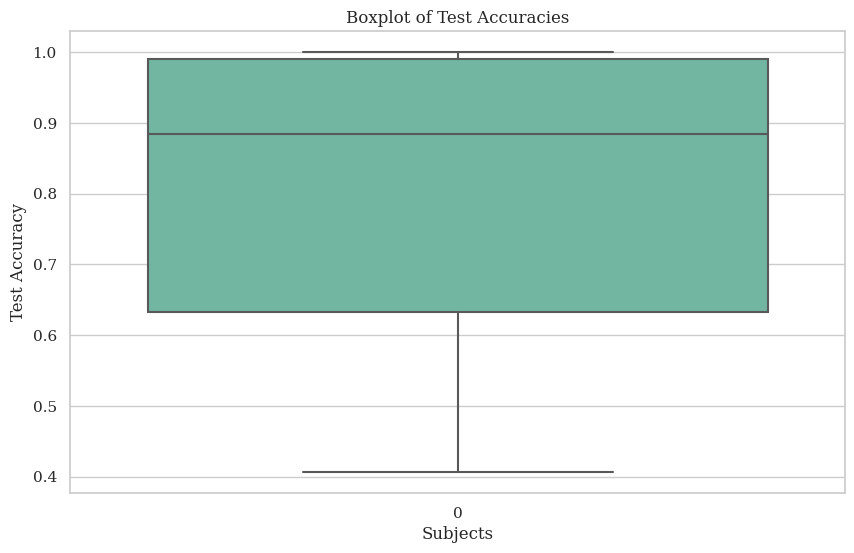

In [6]:
# Set the Seaborn palette
sns.set_palette("Set2")

# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df['test_accuracy'])
plt.title('Boxplot of Test Accuracies')
plt.xlabel('Subjects')
plt.ylabel('Test Accuracy')
plt.show()

# Report of one subject

In [19]:
## TEST
import torch
import pandas as pd

# Initialize variables
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# Define loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Track loss and accuracy per batch
batch_results = []

# Disable gradient calculation for inference
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        # Move data to the appropriate device (GPU/CPU)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass through the model
        outputs = conformer(X_batch)
        
        # Calculate loss
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)

        # Store individual batch results
        batch_results.append({
            'Batch': batch_idx + 1,
            'Loss': loss.item(),
            'Accuracy': (predicted == y_batch).sum().item() / y_batch.size(0)
        })

# Calculate average loss and overall accuracy
test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

# Create DataFrame for detailed batch results
df_results = pd.DataFrame(batch_results)

# Print detailed report
print(f"{'='*60}")
print(f"{'Test Report':^60}")
print(f"{'='*60}")
print(f"Total Batches: {len(test_loader)}")
print(f"Average Test Loss: {test_loss:.4f}")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")
print(f"\nBatch-wise Results:")
print(df_results.to_string(index=False))


                        Test Report                         
Total Batches: 2
Average Test Loss: 1.1538
Overall Test Accuracy: 0.8509

Batch-wise Results:
 Batch     Loss  Accuracy
     1 1.074396  0.859375
     2 1.233160  0.840000


                        Test Report                         
Total Batches: 2
Average Test Loss: 1.1538
Overall Test Accuracy: 0.8509

Batch-wise Results:
 Batch     Loss  Accuracy
     1 1.074396  0.859375
     2 1.233160  0.840000


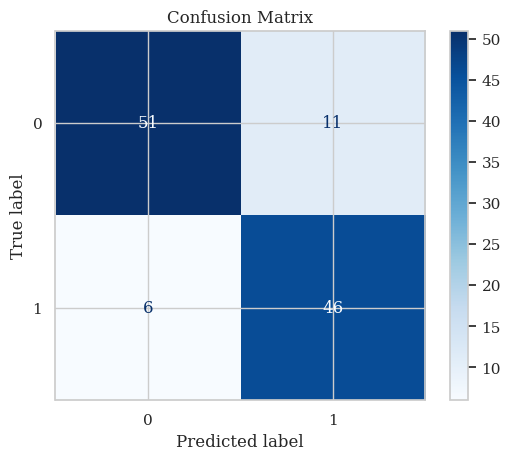

In [22]:
## TEST
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize variables
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_labels = []
all_predictions = []

# Define loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Track loss and accuracy per batch
batch_results = []

# Disable gradient calculation for inference
with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
        # Move data to the appropriate device (GPU/CPU)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass through the model
        outputs = conformer(X_batch)
        
        # Calculate loss
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        correct_predictions += (predicted == y_batch).sum().item()
        total_predictions += y_batch.size(0)
        
        # Store labels and predictions for confusion matrix
        all_labels.extend(y_batch.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Store individual batch results
        batch_results.append({
            'Batch': batch_idx + 1,
            'Loss': loss.item(),
            'Accuracy': (predicted == y_batch).sum().item() / y_batch.size(0)
        })

# Calculate average loss and overall accuracy
test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

# Create DataFrame for detailed batch results
df_results = pd.DataFrame(batch_results)

# Print detailed report
print(f"{'='*60}")
print(f"{'Test Report':^60}")
print(f"{'='*60}")
print(f"Total Batches: {len(test_loader)}")
print(f"Average Test Loss: {test_loss:.4f}")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")
print(f"\nBatch-wise Results:")
print(df_results.to_string(index=False))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
